## Lesson 10
### From Scratch
* In the from scratch versions, I'll be recreating the content from the lessons using only the notes prepared below
* I'll also be using the MNIST Fashion dataset to mix things up

| Step | Notes | Documentation |
| --- | --- | --- |
| 1. Download data | urlretrieve | [link](https://docs.python.org/3/library/urllib.request.html) |
| 1.1 Extract data | gzip | [link](https://docs.python.org/3/library/gzip.html)
| 2. Chunkify lists | | [link](https://docs.python.org/3/library/functions.html) |
| 3. Display image | using matplotlib | [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) |
| 4. Create Tensor Class | tensor[3,4] should work | [link](https://docs.python.org/3/reference/datamodel.html) |

### Other helpful things
* path_data.mkdir(exist_ok=True)
* !ls -1 data

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

#### 1. Download the data

In [354]:
TEST_IMG_URL = "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz?raw=true"
TEST_LABEL_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-labels-idx1-ubyte.gz?raw=true"
TRAIN_IMG_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz?raw=true"
TRAIN_LABEL_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-labels-idx1-ubyte.gz?raw=true"

In [355]:
path_data = Path("fashion_data")
path_data.mkdir(exist_ok=True)
path_train = path_data/"train-images-idx3-ubyte.gz"

In [356]:
from urllib.request import urlretrieve

In [357]:
urlretrieve(TRAIN_IMG_URL, filename=path_train)

(PosixPath('fashion_data/train-images-idx3-ubyte.gz'),
 <http.client.HTTPMessage at 0x7f24007b5050>)

In [358]:
!ls -1 fashion_data

train-images-idx3-ubyte.gz


#### 1.1 Extract the data

In [359]:
#collapse-hide
# taken from https://github.com/datapythonista/mnist/blob/master/mnist/__init__.py
import os
import functools
import operator
import struct
import array
import tempfile

def parse_idx(fd):
    """Parse an IDX file, and return it as an array of arrays.
    
    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse
    endian : str
        Byte order of the IDX file. See [1] for available options
    Returns
    -------
    data : array
        Numpy array with the dimensions and the data in the IDX file
    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))
    return data

In [360]:
# unzip the files and extract the images 
with gzip.open(path_train, 'rb') as f:
    pixels = list(parse_idx(f))

In [361]:
len(pixels)

47040000

These are all the pixels for the entire training set so we need to chunk them into images which are 784 pixels long

#### 2. Chunk the data

In [362]:
def chunk(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

In [363]:
image_chunks = list(chunk(pixels, 784))

In [364]:
len(image_chunks), len(image_chunks[1])

(60000, 784)

In [365]:
train_imgs = [list(chunk(img, 28)) for img in image_chunks]

In [366]:
len(train_imgs), len(train_imgs[0]), len(train_imgs[0][0])

(60000, 28, 28)

#### 3. Display an image

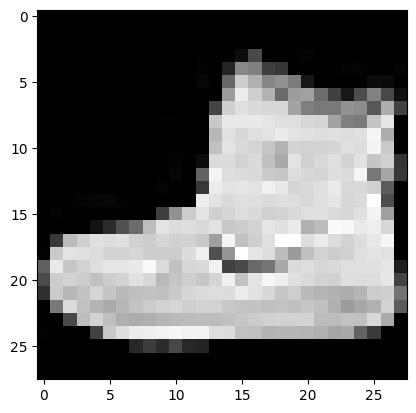

In [367]:
plt.imshow(train_imgs[0])

#### 4. Create a Tensor class

In [368]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [369]:
img = Matrix(train_imgs[0])

In [370]:
img[2,3]

0

In this lesson we implemented from:
* List chunking
* Tesor scripting

Which means we can now use these features as they are implemented in other libraries.

The video lessons also implemented random numbers from scratch but random is part of the standard python library so I did not bother.

## Lesson 11

| Step | Notes | Documentation |
| --- | --- | --- |
| 1. Create a niave matrix multiplication function | | |
| 2. Use PyTorch elementwise ops to increase speed | | [link](https://pytorch.org/docs/stable/generated/torch.dot.html)|
| 3. Use PyTorch broadcasting to further increase the speed | | [link](https://pytorch.org/cppdocs/notes/tensor_indexing.html)

#### 1. Niave approach

In [371]:
import torch

torch.manual_seed(1)
weights = torch.rand(784,10)
bias = torch.zeros(10)
m1 = torch.tensor(image_chunks[:5])
m2 = weights

In [372]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [373]:
def matmul(a, b):
    (ar,ac),(br,bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]

In [374]:
%time _=matmul(m1, m2)

CPU times: user 493 ms, sys: 2 µs, total: 493 ms
Wall time: 492 ms


#### 2. Elementwise Ops 

In [375]:
def matmul(a, b):
    (ar,ac),(br,bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [376]:
%timeit -n 50 matmul(m1, m2)

713 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### 3. Broadcasting

In [377]:
m1[0,:,None].shape

torch.Size([784, 1])

* We've taken the first row of m1, and turned it into a single column matrix

In [378]:
(m1[0,:,None] * m2).shape

torch.Size([784, 10])

* When we multiply it by m2, the matrix gets broadcasted to be in a compatible shape to multiply with m2
* Then we are esentially multiplying the first row in m1 by all the columns in m2 through matrix multiplication and we get a vector as a result

In [379]:
(m1[0,:,None] * m2).sum(dim=0).shape

torch.Size([10])

* Then we sum all the columns to get the first row of our resultant matrix

In [380]:
def matmul(a, b):
    (ar,ac),(br,bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i,:,None]*b).sum(dim=0)
    return c

In [381]:
%timeit -n 50 matmul(m1, m2)

93.9 µs ± 8.74 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [382]:
0.412 / 92.4e-6

4458.8744588744585

Through this process, we've increased the speed of our matrix multiplication from our naive approach by a factor of about 5000x!

## Lesson 12 Part 1 (Part 2 in 02_)
| Step | Notes | Documentation |
| --- | --- | --- |
| 1. Eintein Summation | Implement matmul with einstein summation | [link](https://pytorch.org/docs/stable/generated/torch.einsum.html) |
| 2. PyTorch Op | Implement matmul with PyTorch Op (@) | |
| 3. CUDA | Implement matmul and run it on gpu | |
| | @cuda.jit | |
| | Create a grid | |
| | Loop over rows in first matrix | |
| | Put the data on the gpu (cuda.to_device)| [link](https://numba.pydata.org/numba-doc/0.13/CUDAJit.html) |
| | [blockspergrid, (TPB,TPB)] | |
| | Put the result back on the CPU (copy_to_host) | [link](https://numba.pydata.org/numba-doc/0.13/CUDAJit.html) |
| 4. Torch Cuda | Put the inputs on the gpu | [link](https://pytorch.org/docs/stable/cuda.html) |
| | PyTorch Op | |
| | Put the result on the CPU | [link](https://pytorch.org/docs/stable/cpu.html) |

#### 1. Einstein Summation

In [390]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [401]:
m1,m2

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[0.758, 0.279, 0.403,  ..., 0.754, 0.570, 0.439],
         [0.639, 0.525, 0.683,  ..., 0.498, 0.937, 0.656],
         [0.314, 0.198, 0.416,  ..., 0.772, 0.011, 0.810],
         ...,
         [0.198, 0.611, 0.155,  ..., 0.127, 0.112, 0.805],
         [0.325, 0.366, 0.131,  ..., 0.577, 0.930, 0.056],
         [0.710, 0.201, 0.761,  ..., 0.596, 0.552, 0.151]]))

In [402]:
m1= m1.float()

In [403]:
torch.einsum("ij,jk->ik", m1, m2)

tensor([[39188.984, 37019.160, 40593.422, 38566.141, 35925.922, 38446.547, 36549.461, 38711.676, 36992.492, 38633.809],
        [42420.848, 42914.598, 44270.199, 42826.625, 41253.781, 43048.133, 40055.414, 42347.586, 42641.383, 41230.188],
        [14664.328, 14397.241, 14957.521, 14195.162, 14081.121, 14811.805, 14101.413, 14264.991, 15744.840, 13638.903],
        [23394.113, 23634.238, 24475.088, 24055.564, 23647.275, 23818.494, 22843.998, 23894.293, 23781.828, 22521.004],
        [31064.795, 30976.586, 32092.305, 31240.537, 30529.746, 31704.115, 29437.299, 30499.428, 32891.711, 29428.092]])

In [406]:
def matmul(a, b):
    return torch.einsum("ij,jk->ik", a, b)

In [407]:
%timeit -n 50 matmul(m1, m2)

35.7 µs ± 7.69 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### 2. PyTorch Op

In [417]:
def matmul(a, b):
    return a@b

In [418]:
%timeit -n 50 matmul(m1, m2)

13.8 µs ± 4.77 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### 3. CUDA

In [421]:
from numba import cuda

In [422]:
@cuda.jit
def matmul(a,b,c):
    i,j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]):
            tmp += a[i,k] * b[k,j]
        c[i,j] = tmp



In [442]:
x_train = torch.tensor(image_chunks).float()

In [444]:
tr = x_train@weights
tr.shape

torch.Size([60000, 10])

In [447]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

In [448]:
# Don't need to know the details of this right now
# Just copy it when you need it
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3750, 1)

In [450]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
r.shape

(60000, 10)

In [451]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

6.86 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 4. PyTorch CUDA

In [452]:
m1c, m2c = x_train.cuda(), weights.cuda()

In [453]:
r = (m1c@m2c).cpu()

In [454]:
%timeit -n 10 r=(m1c@m2c).cpu()

1.01 ms ± 677 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
